# Assessing the Accuracy of ML Models

The performance of the trained models is evaluated based on three elements:

- **gridcv_stats**: Stores the `gridcv.best_score_` from `GridSearchCV`. This refers to the cross-validation score obtained during the grid search for each *pipeline*. This score was computed using the *score* `balanced_accuracy`.
- **best_gridcv_stats**: Contains the statistics for the best train/test partition from the `GridSearchCV`, computed using the **test** sample or **validation** data.
- **confusion_matrices**: Saves the confusion matrix for each of the model in best_gridcv_stats.

:::
*Pipeline* refers to each step of the training phase, including combinations of predictor sets, model types, and preprocessing pipelines.
:::


In [1]:
from pathlib import Path
from pathlib import Path
import sys

import shap
import numpy as np
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

# Define the project root path
ROOT = Path.cwd().resolve().parent
# Add custom Python modules to the system path
PYTHON_DIR = ROOT / "Python"
sys.path.insert(0, str(PYTHON_DIR))

# Import custom utilities
from utils import CMatrix as cmatrix  # type: ignore
from utils.model import load_stats, retrieve_model, search_grid  # type: ignore


In [2]:
# Directory where logs from model training are stored.
LOGS_FOLDER = Path(ROOT, "results", "logs", "v0.1")

The notebook includes several graphics. These graphics can be saved in the directory specified by the `graphics_path` variable.

In [3]:
graphics_path = Path(ROOT, "paper", "figures")

Include the labels that describe the types of vegetation.

In [3]:
# Load label codes
label_codes_path = Path(ROOT, "data/labels/label_codes.csv")
label_codes = pd.read_csv(label_codes_path)

# Remove duplicates in the "code_v1_reclass" column.
# Using `drop_duplicates` avoids introducing unintended changes from `.max()`.
# Each unique "code_v1_reclass" will keep the first occurrence.
label_codes = (label_codes
    .drop_duplicates(subset="code_v1_reclass", keep="first")
    # Clean up the index after deduplication
    .reset_index(drop=True)
)

In [4]:
dataset_versions = [1, 2, 3]
# Optional, if a specific log version is required
# dataset_suffixes = {1: "20250904T184058"}
dataset_suffixes = {
    1: "*_spring_summer",
    2: "*_spring_summer",
    3: "*_spring_summer"
}

best_grids: dict[str, dict] = {}
cm_stats: list[dict] = []
grid_best_stats_frames: list[pd.DataFrame] = []

for v in dataset_versions:
    
    if v in dataset_suffixes.keys():
        folder_name = f"train_dataset_v{v}_{dataset_suffixes[v]}"
    else:
        folder_name = f"train_dataset_v{v}"

    grid_stats, cm_best, best_grid = load_stats(folder_name, LOGS_FOLDER)
    # KFold cross validation stats
    best_grids[v] = best_grid
    # Confusion matrices
    cm_stats.extend(cm_best)
    # Results from the test validation
    grid_best_stats_frames.append(grid_stats)

# Concatenate all stats into one DataFrame
grid_best_stats = pd.concat(grid_best_stats_frames, ignore_index=True)


## Pipelines

View the error metrics by pipeline, separating *under* and *over* sampling techniques.

In [5]:
# Function to plot grouped horizontal bars
def plot_grouped_bars(df, title, ax):
    colors = ["#212529", "#6c757d", "#ced4da"]

    dat_over = df.groupby(["over", "dataset"])["data"].mean().unstack()
    dat_under = df.groupby(["under", "dataset"])["data"].mean().unstack()
    dat = pd.concat([dat_over, dat_under])

    y = range(len(dat.index))
    n_datasets = dat.shape[1]   # number of datasets (2, 3, ...)
    bar_height = 0.8 / n_datasets  # shrink bars so they all fit

    # Loop over datasets
    for i, col in enumerate(dat.columns):
        offset = (i - (n_datasets-1)/2) * bar_height
        ax.barh([yy + offset for yy in y],
                dat[col],
                height=bar_height,
                color = colors[i],
                label=f"Dataset {col}")

    ax.set_yticks(y)
    ax.set_yticklabels(dat.index)
    ax.set_xlabel("Score")

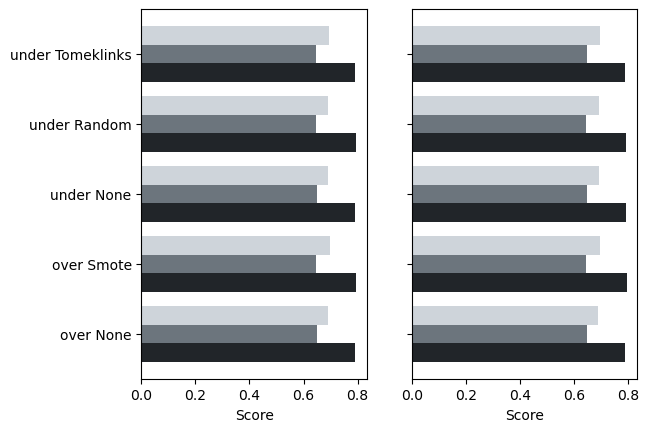

In [6]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

# Split pipeline into oversampling and undersampling
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'rf'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
plot_grouped_bars(dat, "RF", axs[0])

# dat = grid_best_stats.query(q + " and model == 'svm'").copy()
dat[['over', 'under']] = (
    dat["pipe_name"]
    .str.title()
    .str.split('_', n=1, expand=True)
)
dat['over'] = dat['over'].radd("over ")
dat['under'] = dat['under'].radd("under ")
plot_grouped_bars(dat, "SVM", axs[1])

### Max values by balanced accuracy and RF

In [7]:
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'rf'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
pivot = (
    dat.groupby(["over", "under"])["data"]
    .max()
    .unstack(fill_value=None)
)
pivot

under,none,random,tomeklinks
over,,,
none,0.864671,0.874890,0.864671
smote,0.867140,0.872732,0.867140


### Max values by balanced accuracy and SVM

In [8]:
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'svm'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
pivot = (
    dat.groupby(["over", "under"])["data"]
    .max()
    .unstack(fill_value=None)
)
pivot

under,none,random,tomeklinks
over,,,
none,0.907427,0.907427,0.907427
smote,0.900002,0.900002,0.900002


## Assessing Scores

Create one plot per model, showing the balanced accuracy metrics across the three datasets.

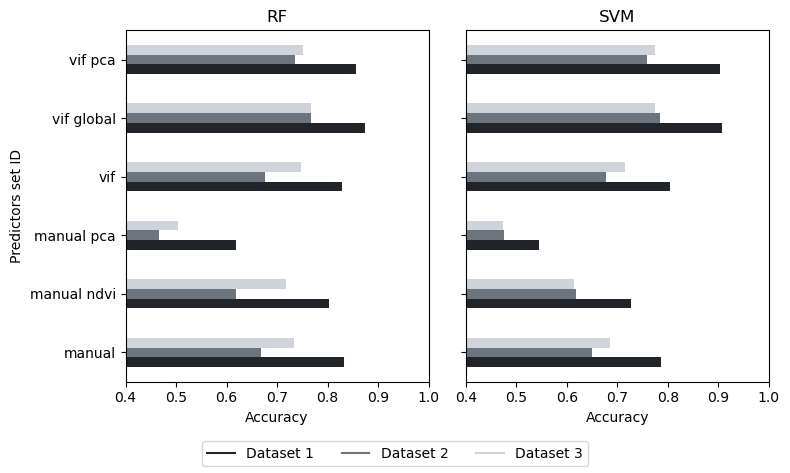

In [9]:
# Plot comparing the two approaches by model and metric
colors = ["#212529", "#6c757d", "#ced4da"]
# colors = ['#a6cee3','#1f78b4','#b2df8a']
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)

for i, model in enumerate(pd.unique(grid_best_stats["model"])):
    
    query = (
        f"(label_code.isnull()) and (model == '{model}') "
        "and (metric == 'balanced_accuracy')"
    )
    
    data = (
        grid_best_stats
        .query(query).groupby(["dataset", "pred_id"])
        .max().unstack("pred_id")
    )["data"]

    # Improve Y axis labels
    data.columns = data.columns.str.replace("_", " ")

    data.T.sort_index().plot(
        kind="barh",
        ax=axs[i],
        color=colors,
        legend=False
    )
    axs[i].set_title(model.upper())
    axs[i].set_xlabel("Accuracy")
    axs[i].set_ylabel("Predictors set ID")
    axs[i].set_xlim([.4, 1])

leg_handles, leg_labels = [], []
for label, color in zip(["Dataset 1", "Dataset 2", "Dataset 3"], colors):
    leg_handles.append(
        axs[0].plot(
            [], [],
            # marker="o",
            color=color,
            label=label
        )[0]
    )
    leg_labels.append(label)

fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
plt.tight_layout(rect=[0, 0.06, 1, 0.95])  # Adjust layout to fit global legend
# Save the figure as an SVG file
# plt.savefig(
#   Path(graphics_path, 'dataset_2_overall_metrics_by_pred.svg'),
#   format='svg'
# )

## Classification Error Metrics by Label

Classification errors for each label were assessed using **Producer’s Accuracy** and **User’s Accuracy**.

- **Producer’s Accuracy**: Measures how well reference sites of a given label are correctly classified.  
  It is equivalent to *100 minus the omission error*, i.e., the percentage of reference sites for that label that are not omitted.

- **User’s Accuracy**: Measures the reliability of a given label assignment in the classification.  
  It is equivalent to *100 minus the commission error*, i.e., the percentage of sites classified as a given label that are not misclassified.


In [10]:
def get_lbl_accuracy_data(
        grid_best_stats,
        label_codes,
        model_key,
        pred_id,
        dataset_v):
    """
    Retrieve classification accuracy data (OA and others) for the best
    predictors.

    Parameters
    ----------
    grid_best_stats : pd.DataFrame
        DataFrame containing statistics of grid search results.
    label_codes : pd.DataFrame
        DataFrame mapping label codes to reclassified codes.
    best_grids : dict
        Dictionary where keys are dataset identifiers and values are dicts with
        at least 'model' and 'pred_id' keys.

    Returns
    -------
    pd.DataFrame
        Grouped DataFrame with maximum classification accuracies by dataset, metric, and label_rc_code.
    """
    # Build the query string template
    fquery = "((model == '{}') and (pred_id == '{}') and (dataset == {}))"

    # Join label codes into stats dataframe
    df = grid_best_stats.join(
        label_codes.set_index("code_v1_reclass")["label_rc_code"],
        on="label_code"
    )
    
    # Filter for producer and user accuracies
    cls_err = df.query(fquery.format(model_key, pred_id, dataset_v))
    cls_err = cls_err.query("metric in ('producer_acc', 'user_acc')")

    # Group and take max per dataset/metric/label
    cls_data = cls_err.groupby(["dataset", "metric", "label_rc_code"]).max()

    return cls_data


In [11]:
g_kappa = grid_best_stats.query("metric=='kappa'")
cls_data = g_kappa.loc[
    g_kappa.groupby(["model", "dataset"])["data"].idxmax()
].sort_values(by=["data", "dataset"], ascending=False)

In [12]:
cls_data

,model,metric,label_code,data,pipe_name,pred_id,dataset
1945,svm,kappa,NaN,0.890834,none_tomeklinks,vif_global,1
1800,rf,kappa,NaN,0.873946,smote_random,vif_global,1
5251,svm,kappa,NaN,0.704906,smote_tomeklinks,vif_pca,3
6208,rf,kappa,NaN,0.682966,none_none,vif_global,3
4120,rf,kappa,NaN,0.662875,none_none,vif_global,2
3859,svm,kappa,NaN,0.650473,smote_tomeklinks,vif_global,2


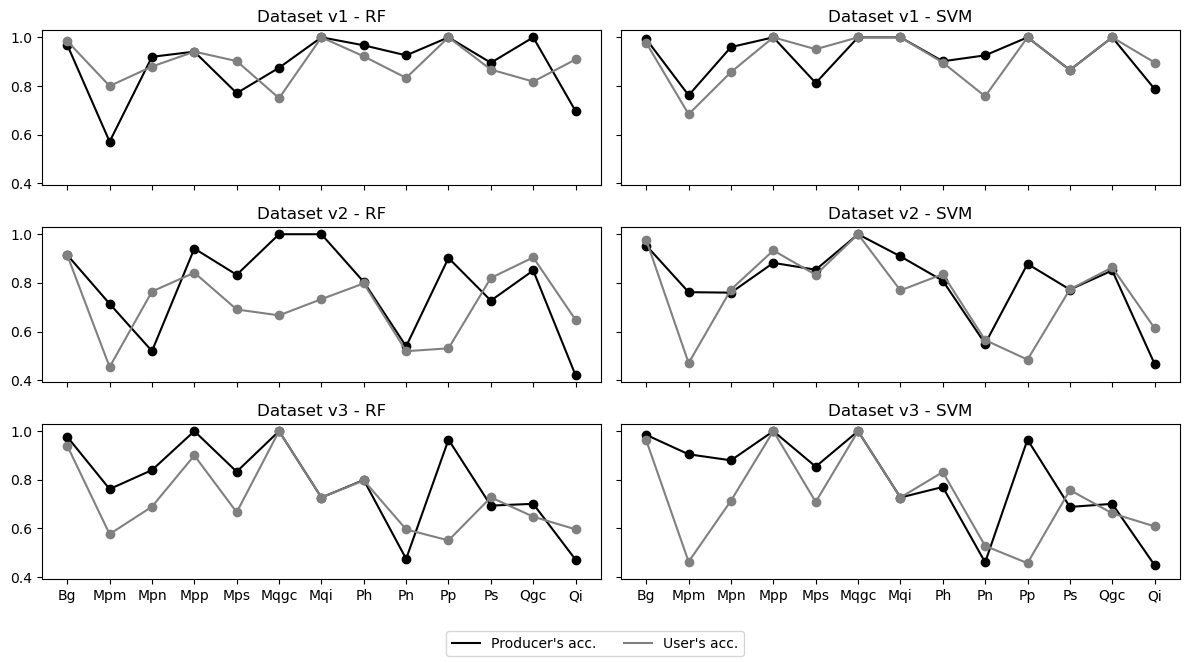

In [13]:
# Best models by Kappa metric per dataset
fig, axs = plt.subplots(3, 2, figsize=(12,7), sharey=True, sharex=True)

i = 0
for r_id, col_values in cls_data.query("model == 'rf'").iterrows():
    plot_data = get_lbl_accuracy_data(
        grid_best_stats,
        label_codes,
        col_values["model"],
        col_values["pred_id"],
        col_values["dataset"]
    )

    axs[i, 0].plot(
        plot_data.loc[(col_values["dataset"], 'producer_acc'), "data"],
        color="black",
        marker='o'
    )
    axs[i, 0].plot(
        plot_data.loc[(col_values["dataset"], 'user_acc'), "data"],
        color="grey",
        marker='o'
    )
    axs[i, 0].set_title(f"Dataset v{i+1} - RF")
    i=i+1

i = 0
for r_id, col_values in cls_data.query("model == 'svm'").iterrows():
    plot_data = get_lbl_accuracy_data(
        grid_best_stats,
        label_codes,
        col_values["model"],
        col_values["pred_id"],
        col_values["dataset"]
    )

    axs[i, 1].plot(
        plot_data.loc[(col_values["dataset"], 'producer_acc'), "data"],
        color="black",
        marker='o'
    )
    axs[i, 1].plot(
        plot_data.loc[(col_values["dataset"], 'user_acc'), "data"],
        color="grey",
        marker='o'
    )
    axs[i, 1].set_title(f"Dataset v{i+1} - SVM")
    i=i+1

# Cambiar el titulo de "species", son comunidades vegetales
# plt.legend(title="Species")
leg_handles, leg_labels = [], []
for label, color in zip(["Producer's acc.", "User's acc."], ["black", "grey"]):
    leg_handles.append(
        axs[0, 0].plot(
            [], [],
            # marker="o",
            color=color,
            label=label
        )[0]
    )
    leg_labels.append(label)

fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
fig.tight_layout(rect=[0, 0.06, 1, 0.95])  # Adjust layout to fit global legend

# Save the figure as an SVG file
# plt.savefig(Path(graphics_path, 'accuracy_by_cls.svg'), format='svg')

## Confusion Matrix

In [ ]:
def show_cm(cm_dict, labels):
    """Retrieve and plot the target Confusion Matrix"""
    # Join confusion matrix label codes with their names
    cm_labels = pd.DataFrame(cm_dict['labels'], columns=["code"])
    cm_labels = cm_labels.join(labels.set_index("code_v1_reclass"), on="code")
    
    # Create a custom dataframe with data and real labels
    cm = pd.DataFrame(cm_dict["cm"],
                      index=cm_labels['label_rc_code'], columns=cm_labels['label_rc_code'])

    title = f"{cm_dict["model"]} | {cm_dict["pipe"]} | {cm_dict["pred_id"]}"
    cmatrix(cm).pp_matrix(cmap="gray_r", fz=7, pred_val_axis='col',
                          figsize=[6, 6], cmtitle=title)

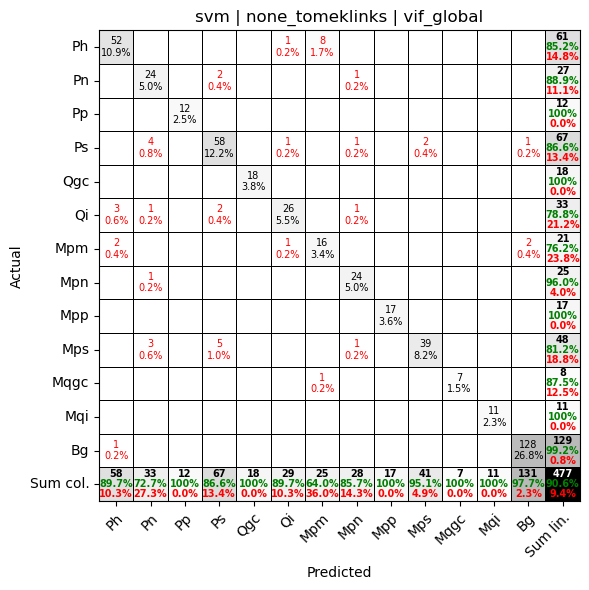

In [15]:
target_cm_model = cls_data.query("model == 'svm'")
target_cm = search_grid(
    cm_stats,
    **{
        "pred_id": target_cm_model.iloc[0]["pred_id"],
        "model": target_cm_model.iloc[0]["model"],
        "pipe": target_cm_model.iloc[0]["pipe_name"],
        "dataset": target_cm_model.iloc[0]["dataset"]
    }
)
show_cm(target_cm, label_codes)

## SHapley Additive exPlanations

[SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) provides both global feature importance (which features matter most across the dataset) and local explanations (which features drive an individual prediction).

Select the model to compute the explanations. There are two options:

- Use the keys inside a grid dictionary.
- Write the desired ones at the end of the function.

In [36]:
# Import labels and apply pretreatments described in inspect_predictors.ipynb
labels_dataset_path = Path(ROOT, "results/dataset.csv")

dataset_v = 1
mtype = "summer_long"

model, pipe, pred_vars_list, model_params, X_train, X_test = retrieve_model(
    LOGS_FOLDER,
    # Folder containing the training logs
    best_grids[dataset_v]["folder_name"],
    labels_dataset_path,
    label_codes_path,
    model_type = mtype,
    **best_grids[dataset_v]
)

### SVM SHAP

In [ ]:
# SHAP doesn’t have a specialized explainer for SVMs.
# KernelExplainer is mandatory, which is model-agnostic but slower
# KernelExplainer (model-agnostic)
if model.key == "svm":
    explainer = shap.KernelExplainer(
        model.get_clf().predict_proba, X_train.sample(50, random_state=42))
    # background dataset = 50 samples for efficiency

    # Compute SHAP values for a subset of test data (computationally expensive)
    shap_values = explainer.shap_values(X_test.iloc[:30, :])
else:
    print("Provide an SVM model.")

### Tree SHAP

In [45]:
if model.key == "rf":
    # SHAP has a fast, optimized algorithm for tree classifiers
    # SHAP explainer for tree models
    explainer = shap.TreeExplainer(model.get_clf())

    # Multiclass problem:
    # shap_values will be a list with one array per class,
    # each of shape (n_samples, n_features)
    shap_values = explainer.shap_values(X_train)
else:
    print("Provide an RF model.")

Provide an RF model.


### SHAP values

In [38]:
# --- Option 1: aggregate across classes ---
# Take absolute values, mean over samples and classes
mean_abs_shap_per_feature = np.mean(np.abs(shap_values), axis=(0, 2))
max_abs_shap_per_feature = np.max(np.abs(shap_values), axis=(0, 2))

# --- Option 2: keep per-class importance ---
# Take absolute values, mean over samples only
mean_abs_shap_per_feature_class = np.mean(np.abs(shap_values), axis=0)

In [39]:
shap_abs_vals = pd.DataFrame({
    "abs_max": mean_abs_shap_per_feature,
    "abs_mean": max_abs_shap_per_feature
}, index=X_train.columns).sort_values(by=["abs_mean"])

<BarContainer object of 6 artists>

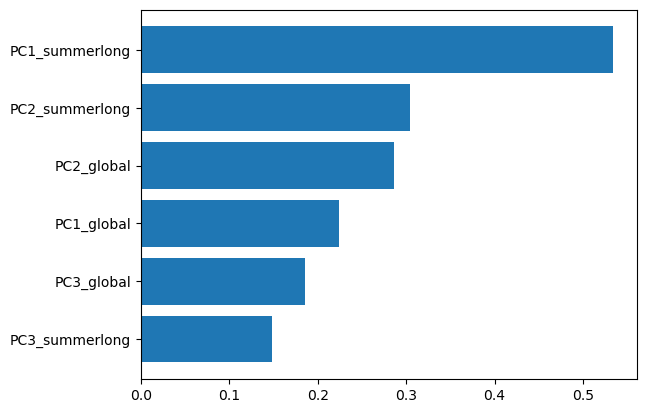

In [40]:
fig, axs = plt.subplots(1, 1, sharey=True)

axs.barh(shap_abs_vals.index, shap_abs_vals["abs_mean"])

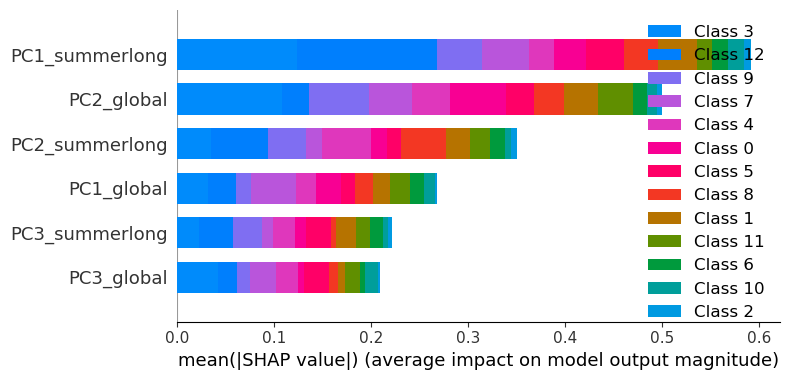

In [41]:
# Global importance bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar")